# Case Picpay- Modelo de classificação para credit score

O desafio é a construção de um modelo de Credit Scoring cuja base de dados está
localizada no link. O arquivo contém 81 variáveis e 10.738 registros, sendo que o "id" é a
chave única da tabela, "safra" é o mês ano de concessão do crédito, "y" é a variável target e
as demais são variáveis preditoras mascaradas.
Seu trabalho consiste em:

* Desenvolver um modelo para predizer a variável target
* Justificar o algoritmo e parâmetros utilizados
* Apresentar métricas de performance do modelo
* Explicar e apresentar os resultados

### 1.Exploratória da base

In [2]:
import pandas as pd
import numpy as np
import seaborn as srn
from sklearn.cluster import DBSCAN
import warnings
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import joblib
import optuna
import logging
from scipy.stats import ks_2samp
from boruta import BorutaPy
import inflection
from scipy.stats import chi2_contingency
from xgboost import XGBClassifier

In [3]:
df = pd.read_csv('base_modelo.csv')

In [4]:
df.shape

(10738, 81)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10738 entries, 0 to 10737
Data columns (total 81 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      10738 non-null  int64  
 1   safra   10738 non-null  int64  
 2   y       10738 non-null  int64  
 3   VAR_1   10322 non-null  float64
 4   VAR_2   10322 non-null  float64
 5   VAR_3   10322 non-null  float64
 6   VAR_4   10322 non-null  float64
 7   VAR_5   6678 non-null   float64
 8   VAR_6   10647 non-null  float64
 9   VAR_7   6106 non-null   float64
 10  VAR_8   5905 non-null   float64
 11  VAR_9   10738 non-null  float64
 12  VAR_10  5173 non-null   float64
 13  VAR_11  5754 non-null   float64
 14  VAR_12  3541 non-null   float64
 15  VAR_13  5520 non-null   float64
 16  VAR_14  5197 non-null   float64
 17  VAR_15  5684 non-null   float64
 18  VAR_16  3631 non-null   float64
 19  VAR_17  6237 non-null   float64
 20  VAR_18  3615 non-null   float64
 21  VAR_19  10677 non-null  float64
 22

#### 1.1 Entendimento target e variáveis inteiras

In [6]:
df.y.value_counts(normalize=True, dropna=False)

y
0    0.708698
1    0.291302
Name: proportion, dtype: float64

In [7]:
df.safra.value_counts(normalize=True, dropna=False)

safra
201405    0.090520
201407    0.090147
201404    0.088936
201410    0.086888
201408    0.084932
201406    0.084001
201402    0.083628
201409    0.081673
201403    0.081300
201401    0.079531
201411    0.075247
201412    0.073198
Name: proportion, dtype: float64

In [8]:
df_exp = df.loc[:,df.columns.str.startswith('VAR')]
df_exp.select_dtypes(include=['integer']).columns

Index(['VAR_20', 'VAR_57', 'VAR_64'], dtype='object')

In [9]:
df_exp.VAR_20.value_counts(dropna=False, normalize=True).sort_values(ascending=False)

VAR_20
12    0.699106
10    0.079903
6     0.059415
5     0.039486
8     0.038648
3     0.037717
4     0.023747
7     0.012386
9     0.008475
11    0.001118
Name: proportion, dtype: float64

In [10]:
df_exp.VAR_57.value_counts(dropna=False).sort_values(ascending=False)

VAR_57
47    321
45    314
50    313
46    312
48    300
     ... 
76     28
75     28
78     14
77     13
18     11
Name: count, Length: 61, dtype: int64

In [11]:
df_exp.VAR_57.describe()
# Idade do cliente

count    10738.000000
mean        45.963308
std         12.847511
min         18.000000
25%         36.000000
50%         46.000000
75%         55.000000
max         78.000000
Name: VAR_57, dtype: float64

In [12]:
df_exp.VAR_64.value_counts()

VAR_64
1    6519
0    4219
Name: count, dtype: int64

* 30% dos contratos possuem inadimplẽncia
* Os contratos são referentes ao ano de 2014 com "fatias" de ~10% da base por mês
* Todas as variáveis explicativas são numéricas
* Apenas 3 variáveis são inteiras e não possuem nulos:
* VAR20 com range de 3 a 12, concentração de 70% em 12, imagino ser a quantidade de parcelas
* VAR57 com range de 18 a 78, imagino ser a idade do cliente
* VAR64 binária

#### 1.2 Entendimento das variáveis com valores ausentes

In [13]:
df_miss = ((df.isnull().sum() / len(df)) * 100).reset_index()

df_miss.columns=['columns','n_miss']
df_miss[df_miss['n_miss']>40].shape

(52, 2)

In [14]:
78-52

26

#### 1.2.1 Concentração de missings por safra?

In [15]:
df_miss[(df_miss['n_miss']>10) & (df_miss['n_miss']<40)]

,columns,n_miss
7,VAR_5,37.809648
26,VAR_24,37.809648
55,VAR_53,16.381077
56,VAR_54,11.873720
60,VAR_58,37.809648
67,VAR_65,20.851183


In [16]:
df_for_test_corr=df_miss[(df_miss['n_miss']>10) & (df_miss['n_miss']<40)]['columns'].tolist()

In [17]:
df_for_test_corr

['VAR_5', 'VAR_24', 'VAR_53', 'VAR_54', 'VAR_58', 'VAR_65']

In [18]:
# Testar distribuição de nulos por safra
for var in df_for_test_corr:
    print(var)
    print(df[df[var].isnull()]['safra'].value_counts(normalize=True))
    print('___________________________')

VAR_5
safra
201407    0.095074
201404    0.093103
201410    0.092857
201406    0.090148
201409    0.086453
201408    0.085961
201405    0.084729
201403    0.079310
201411    0.075123
201412    0.073645
201401    0.071921
201402    0.071675
Name: proportion, dtype: float64
___________________________
VAR_24
safra
201407    0.095074
201404    0.093103
201410    0.092857
201406    0.090148
201409    0.086453
201408    0.085961
201405    0.084729
201403    0.079310
201411    0.075123
201412    0.073645
201401    0.071921
201402    0.071675
Name: proportion, dtype: float64
___________________________
VAR_53
safra
201410    0.262649
201409    0.245594
201411    0.229676
201412    0.217169
201408    0.032973
201407    0.002843
201404    0.002274
201402    0.002274
201406    0.001706
201405    0.001137
201401    0.001137
201403    0.000569
Name: proportion, dtype: float64
___________________________
VAR_54
safra
201401    0.441569
201402    0.428235
201404    0.029804
201405    0.021961
201403

Não foi identificada uma safra em comum para as variáveis que tem maior percentual de nulos

#### 1.2.2 Correlação com target dentre as variáveis com maiores percentuais de valores ausentes
Validar correlação com a resposta para entendimento se faz sentido manter a imputação de valores, que em alguns casos é ~40%

In [19]:
df_miss[(df_miss['n_miss']>10) & (df_miss['n_miss']<40)].sort_values(by='n_miss')

,columns,n_miss
56,VAR_54,11.873720
55,VAR_53,16.381077
67,VAR_65,20.851183
7,VAR_5,37.809648
26,VAR_24,37.809648
60,VAR_58,37.809648


<Axes: xlabel='y', ylabel='VAR_5'>

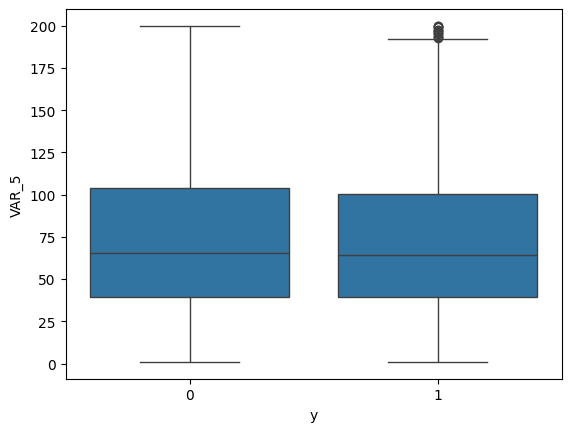

In [20]:
df_cor = df[['y','VAR_5']].dropna()
srn.boxplot(x='y', y='VAR_5', data=df[df['VAR_5']<200])

<Axes: xlabel='y', ylabel='VAR_24'>

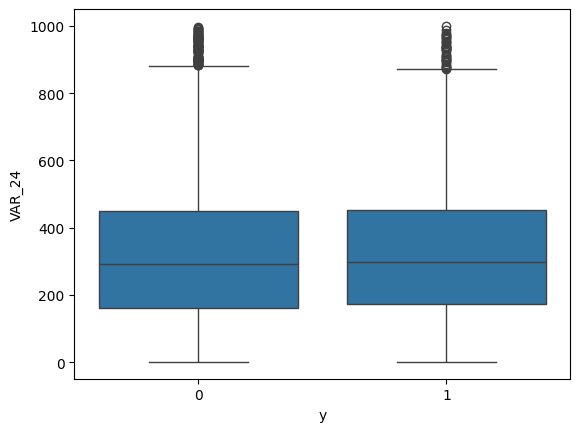

In [21]:
df_cor = df[['y','VAR_24']].dropna()
srn.boxplot(x='y', y='VAR_24', data=df[df['VAR_24']<1000])

<Axes: xlabel='y', ylabel='VAR_58'>

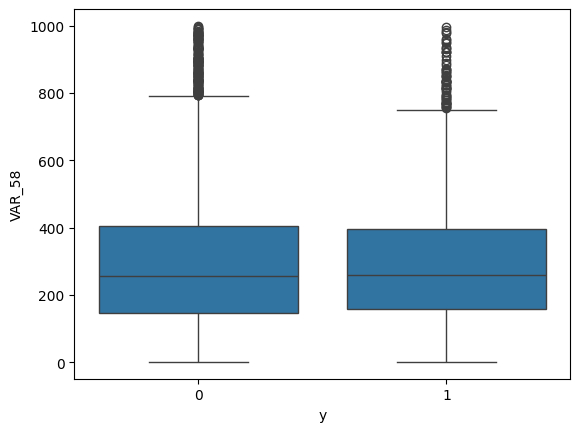

In [22]:
df_cor = df[['y','VAR_58']].dropna()
srn.boxplot(x='y', y='VAR_58', data=df[df['VAR_58']<1000])

In [23]:
cols_to_drop=df_miss[df_miss['n_miss']>40]['columns'].unique().tolist()

In [24]:
to_drop = cols_to_drop + ['VAR_5','VAR_24','VAR_58']
df_for_feature_selection  = df.drop(columns = to_drop)

In [25]:
df_for_feature_selection.columns

Index(['id', 'safra', 'y', 'VAR_1', 'VAR_2', 'VAR_3', 'VAR_4', 'VAR_6',
       'VAR_9', 'VAR_19', 'VAR_20', 'VAR_22', 'VAR_25', 'VAR_28', 'VAR_30',
       'VAR_32', 'VAR_33', 'VAR_40', 'VAR_44', 'VAR_53', 'VAR_54', 'VAR_57',
       'VAR_60', 'VAR_64', 'VAR_65', 'VAR_72'],
      dtype='object')

#### 1.2.4 Conclusões valores ausentes

* 52 variáveis explicativas tem mais de 40% de valores ausentes
* A escolha para retirar essas variáveis reflete inicialmente a falta do seu rótulo para identificar alguma hipótese de correlação com o target, mais que 40% da informação será imputada e isso não reflete o comportamento da variável, o interessante seria ter pelo menos 60% da variável completa, justificando a escolha do corte
* Não encontrou-se uma safra em comum para representar um erro da base em um período específico 
* Existem 3 variáveis com mesmo % de valores ausentes, ~40%, essas não aparentam estar relacionada com o target, portanto serão retiradas também.
* Restaram então 23 features explicativas para tratamento e seleção automática

### 2. pré-processamento 
* Tratamento de missings e outliers: mediana das variáveis agrupadas pela VAR_57(Idade)

#### 2.1 Missing

In [26]:
list_cols_input_miss = df_for_feature_selection.select_dtypes('float').columns.tolist()

In [27]:
def input_median(row, med): 
    
    if np.isnan(row[var]):
        return med.get((row['VAR_57']), np.nan) 
    else:
        return row[var]  

In [28]:
for var in list_cols_input_miss:
    med = df_for_feature_selection.groupby(['VAR_57'])[var].median()
    df_for_feature_selection[f'{var}_input'] = df_for_feature_selection.apply(input_median, axis=1, med=med)

In [30]:
df_for_feature_selection.columns

Index(['id', 'safra', 'y', 'VAR_1', 'VAR_2', 'VAR_3', 'VAR_4', 'VAR_6',
       'VAR_9', 'VAR_19', 'VAR_20', 'VAR_22', 'VAR_25', 'VAR_28', 'VAR_30',
       'VAR_32', 'VAR_33', 'VAR_40', 'VAR_44', 'VAR_53', 'VAR_54', 'VAR_57',
       'VAR_60', 'VAR_64', 'VAR_65', 'VAR_72', 'VAR_1_input', 'VAR_2_input',
       'VAR_3_input', 'VAR_4_input', 'VAR_6_input', 'VAR_9_input',
       'VAR_19_input', 'VAR_22_input', 'VAR_25_input', 'VAR_28_input',
       'VAR_30_input', 'VAR_32_input', 'VAR_33_input', 'VAR_40_input',
       'VAR_44_input', 'VAR_53_input', 'VAR_54_input', 'VAR_60_input',
       'VAR_65_input', 'VAR_72_input'],
      dtype='object')

#### 2.2 Outlier

##### Describe variáveis

In [31]:
# colunas que devem ser tratadas
cols = ['VAR_1_input',
       'VAR_2_input', 'VAR_3_input', 'VAR_4_input', 'VAR_6_input',
       'VAR_9_input', 'VAR_19_input', 'VAR_22_input', 'VAR_25_input',
       'VAR_28_input', 'VAR_30_input', 'VAR_32_input', 'VAR_33_input',
       'VAR_40_input', 'VAR_44_input', 'VAR_53_input', 'VAR_54_input',
       'VAR_60_input', 'VAR_65_input', 'VAR_72_input']
for c in cols:
    print(c)
    print(df_for_feature_selection[[c]].describe())
    print('____________________')

VAR_1_input
        VAR_1_input
count  10738.000000
mean      32.306947
std       45.596838
min        0.000000
25%        0.000000
50%       16.000000
75%       41.750000
max      208.000000
____________________
VAR_2_input
        VAR_2_input
count  10738.000000
mean       0.357888
std        1.236104
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       17.000000
____________________
VAR_3_input
        VAR_3_input
count  10738.000000
mean       0.274632
std        0.851731
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       11.000000
____________________
VAR_4_input
        VAR_4_input
count  10738.000000
mean       0.553921
std        1.195100
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max       13.000000
____________________
VAR_6_input
         VAR_6_input
count   10738.000000
mean     1484.864640
std      7305.926437
min       -94.000000
25%       449.000000
50%       

Uma boa parte das variáveis consideradas como float, parecem ser inteiras e com boa parte das informações igual a 0, ou seja, a mediana se torna 0 e todas as linhas podem se tornar 0.
Dessa forma, seleciona-se apenas algumas delas que parecem possuir outliers de acordo com sua distribuição

##### Tratamento

In [32]:
cols_outliers=['VAR_1_input','VAR_6_input','VAR_30_input','VAR_53_input','VAR_54_input','VAR_65_input','VAR_72_input']

In [37]:
for col in cols_outliers:
    Q1 = df_for_feature_selection[col].quantile(0.25)
    Q3 = df_for_feature_selection[col].quantile(0.75)
    IQR = Q3 - Q1
    LI = Q1 - 1.5 * IQR
    LS = Q3 + 1.5 * IQR
    
    df_for_feature_selection[f'{col}_outlier'] = df_for_feature_selection[col].apply(lambda x: True if x < LI or x > LS else False)    
    

In [33]:
df_for_feature_selection.columns

Index(['id', 'safra', 'y', 'VAR_1', 'VAR_2', 'VAR_3', 'VAR_4', 'VAR_6',
       'VAR_9', 'VAR_19', 'VAR_20', 'VAR_22', 'VAR_25', 'VAR_28', 'VAR_30',
       'VAR_32', 'VAR_33', 'VAR_40', 'VAR_44', 'VAR_53', 'VAR_54', 'VAR_57',
       'VAR_60', 'VAR_64', 'VAR_65', 'VAR_72', 'VAR_1_input', 'VAR_2_input',
       'VAR_3_input', 'VAR_4_input', 'VAR_6_input', 'VAR_9_input',
       'VAR_19_input', 'VAR_22_input', 'VAR_25_input', 'VAR_28_input',
       'VAR_30_input', 'VAR_32_input', 'VAR_33_input', 'VAR_40_input',
       'VAR_44_input', 'VAR_53_input', 'VAR_54_input', 'VAR_60_input',
       'VAR_65_input', 'VAR_72_input'],
      dtype='object')

In [35]:
df_fim = pd.DataFrame()
list_idade = df_for_feature_selection['VAR_57'].unique().tolist()

In [38]:
warnings.simplefilter("ignore")
df_test = df_for_feature_selection.copy()

for col in cols_outliers:
    df_fim = pd.DataFrame()
    for s in list_idade:
        df_group = df_for_feature_selection[df_for_feature_selection['VAR_57']==s]
        med = df_group[col].median().astype('float64')
        df_group[f'{col}_2'] = df_group.apply(lambda x: med if x[f'{col}_outlier'] else x[col], axis=1)
        df_fim = pd.concat([df_fim,df_group])

    df_test = df_test.merge(df_fim[['id',f'{col}_2']], on='id')
    

In [39]:
df_for_automatic_selection = df_test[['id', 'safra', 'y','VAR_1_input_2', 'VAR_2_input',
       'VAR_3_input', 'VAR_4_input', 'VAR_6_input_2', 'VAR_9_input',
       'VAR_19_input', 'VAR_22_input', 'VAR_25_input', 'VAR_28_input',
       'VAR_30_input_2', 'VAR_32_input', 'VAR_33_input', 'VAR_40_input',
       'VAR_44_input', 'VAR_53_input_2', 'VAR_54_input_2', 'VAR_60_input',
       'VAR_65_input_2', 'VAR_72_input_2']]

### 3.Seleção de variáveis

#### 3.1Seleção automática de variáveis
* Boruta: as variáveis originais são comparadas com suas sombras, em que para cada variável, temos suas replicas de forma embaralhada e se a original possuir uma importância maior que a sua sombra significa que ela é realmente explicativa e seguirá até a última interação com a resposta se foi realmente importante

In [42]:
df_for_automatic_selection.columns

Index(['id', 'safra', 'y', 'VAR_1_input_2', 'VAR_2_input', 'VAR_3_input',
       'VAR_4_input', 'VAR_6_input_2', 'VAR_9_input', 'VAR_19_input',
       'VAR_22_input', 'VAR_25_input', 'VAR_28_input', 'VAR_30_input_2',
       'VAR_32_input', 'VAR_33_input', 'VAR_40_input', 'VAR_44_input',
       'VAR_53_input_2', 'VAR_54_input_2', 'VAR_60_input', 'VAR_65_input_2',
       'VAR_72_input_2'],
      dtype='object')

In [43]:
# utilização de 9 meses para treino e 3 meses finais para test
df_safra_train = df_for_automatic_selection[df_for_automatic_selection['safra'] <= 201409]
df_safra_test = df_for_automatic_selection[df_for_automatic_selection['safra'] > 201409]

X_train = df_safra_train.loc[:,df_safra_train.columns.str.startswith('VAR')]
y_train = df_safra_train['y']
X_test = df_safra_train.loc[:,df_safra_test.columns.str.startswith('VAR')]
y_test = df_safra_test['y']

rf = rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5, random_state=42)

boruta =BorutaPy( rf, n_estimators='auto', verbose=0, random_state=42 ).fit(X_train, y_train)

In [44]:
cols_selected = boruta.support_.tolist()

In [45]:
list_features = X_train.iloc[:, cols_selected].columns.to_list()
print(len(list_features))
list_features

20


['VAR_1_input_2',
 'VAR_2_input',
 'VAR_3_input',
 'VAR_4_input',
 'VAR_6_input_2',
 'VAR_9_input',
 'VAR_19_input',
 'VAR_22_input',
 'VAR_25_input',
 'VAR_28_input',
 'VAR_30_input_2',
 'VAR_32_input',
 'VAR_33_input',
 'VAR_40_input',
 'VAR_44_input',
 'VAR_53_input_2',
 'VAR_54_input_2',
 'VAR_60_input',
 'VAR_65_input_2',
 'VAR_72_input_2']

#### 3.2 Seleção de variáveis manual
* Aplicação de modelo Random Forest para verificar a importância das variáveis

<BarContainer object of 20 artists>

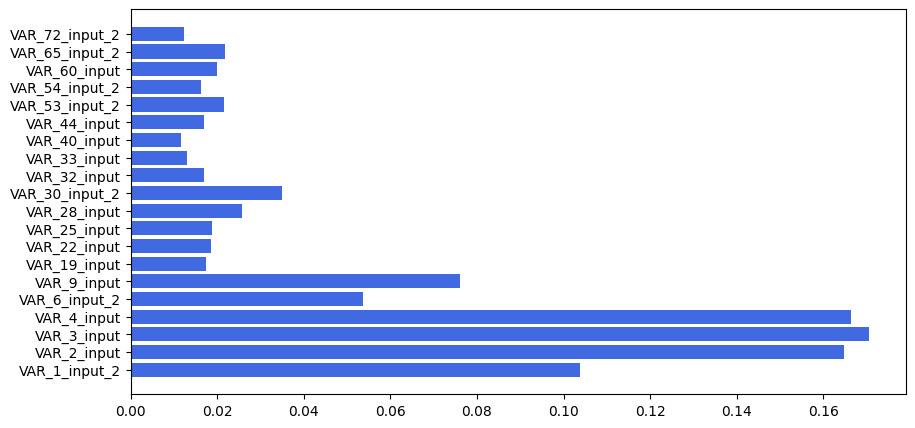

In [46]:
model = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5, random_state=42)

rf = model.fit(X_train, y_train)

importances = rf.feature_importances_
feature_names= list_features

plt.figure(figsize=(10,5))
plt.barh(feature_names, importances, color="royalblue")

In [47]:
df_importance = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values(by='importance',ascending=False)
df_importance

,feature,importance
2,VAR_3_input,0.170471
3,VAR_4_input,0.166287
1,VAR_2_input,0.164698
0,VAR_1_input_2,0.103694
5,VAR_9_input,0.075964
4,VAR_6_input_2,0.053606
10,VAR_30_input_2,0.034903
9,VAR_28_input,0.025684
18,VAR_65_input_2,0.021709
15,VAR_53_input_2,0.021463


In [50]:
list_final_features = df_importance[df_importance['importance']>0.05]['feature'].unique().tolist()

In [51]:
list_final_features

['VAR_3_input',
 'VAR_4_input',
 'VAR_2_input',
 'VAR_1_input_2',
 'VAR_9_input',
 'VAR_6_input_2']

##### boxplots

VAR_3_input


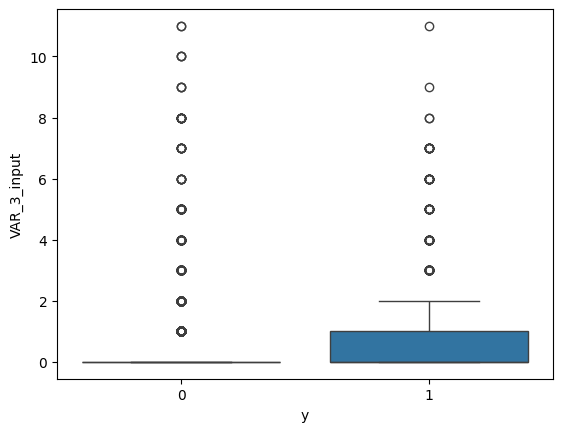

VAR_4_input


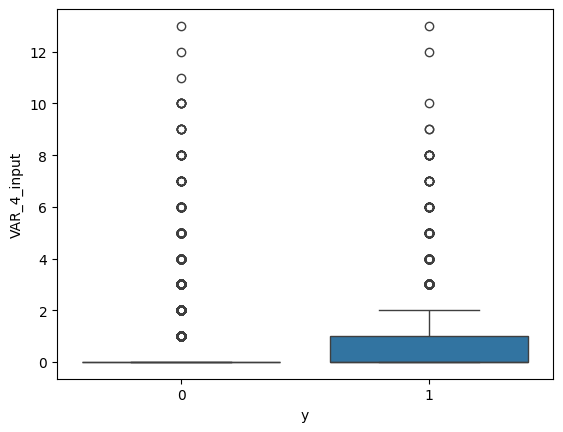

VAR_2_input


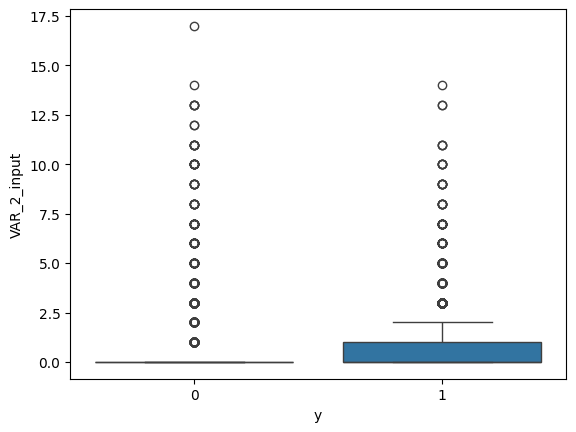

VAR_1_input_2


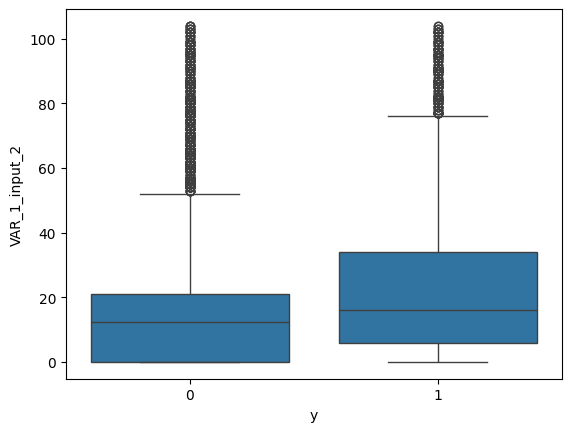

VAR_9_input


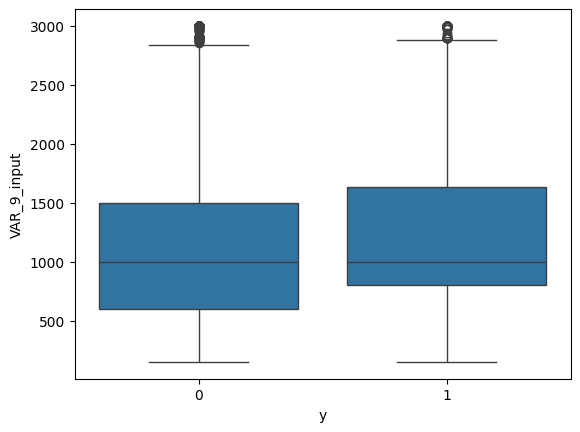

VAR_6_input_2


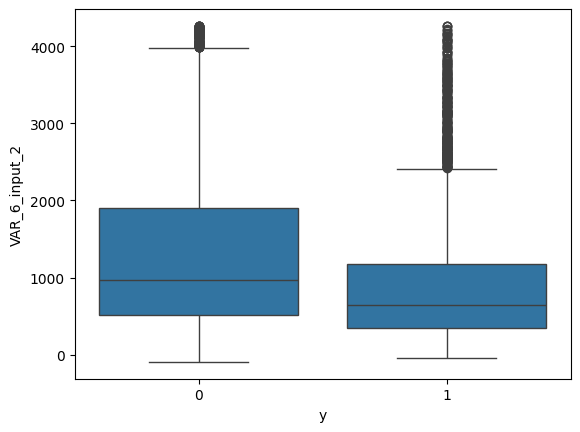

In [52]:
for v in list_final_features:
    print(v)
    srn.boxplot(x='y', y=v, data=df_for_automatic_selection)
    plt.show()

In [53]:
df_for_automatic_selection['VAR_3_input_2']=df_for_automatic_selection['VAR_3_input'].apply(lambda x: 1 if x>0 else 0)
df_for_automatic_selection['VAR_2_input_2']=df_for_automatic_selection['VAR_2_input'].apply(lambda x: 1 if x>0 else 0)
df_for_automatic_selection['VAR_4_input_2']=df_for_automatic_selection['VAR_4_input'].apply(lambda x: 1 if x>0 else 0)

In [54]:
list_columns = ['VAR_3_input_2','VAR_2_input_2','VAR_4_input_2']

In [55]:
# Teste qui-quadrado
for var in list_columns :

  tab_biv = pd.crosstab(df_for_automatic_selection[var], df_for_automatic_selection["y"])

  # Aplicando o teste qui-quadrado
  chi2, p, dof, esperado = chi2_contingency(tab_biv)


  print(var)
  print("Estatística Qui-Quadrado:", chi2)
  print("Valor-p:", p)
  if p<0.05:
    print('Rejeitamos H0, existe associação')
  else:
    print('Não rejeitamos H0, variáveis independentes')

  print('______________________________________')

VAR_3_input_2
Estatística Qui-Quadrado: 872.8491740680931
Valor-p: 7.837623560414276e-192
Rejeitamos H0, existe associação
______________________________________
VAR_2_input_2
Estatística Qui-Quadrado: 917.400357212767
Valor-p: 1.6189449391882026e-201
Rejeitamos H0, existe associação
______________________________________
VAR_4_input_2
Estatística Qui-Quadrado: 734.047055926967
Valor-p: 1.18085220630772e-161
Rejeitamos H0, existe associação
______________________________________


In [56]:
df_for_automatic_selection.columns

Index(['id', 'safra', 'y', 'VAR_1_input_2', 'VAR_2_input', 'VAR_3_input',
       'VAR_4_input', 'VAR_6_input_2', 'VAR_9_input', 'VAR_19_input',
       'VAR_22_input', 'VAR_25_input', 'VAR_28_input', 'VAR_30_input_2',
       'VAR_32_input', 'VAR_33_input', 'VAR_40_input', 'VAR_44_input',
       'VAR_53_input_2', 'VAR_54_input_2', 'VAR_60_input', 'VAR_65_input_2',
       'VAR_72_input_2', 'VAR_3_input_2', 'VAR_2_input_2', 'VAR_4_input_2'],
      dtype='object')

### 4.Teste de algoritmos

In [58]:
#lista de features mais relevantes
list_final_features

['VAR_3_input',
 'VAR_4_input',
 'VAR_2_input',
 'VAR_1_input_2',
 'VAR_9_input',
 'VAR_6_input_2']

In [57]:
list_final_features_transform=['VAR_1_input_2','VAR_2_input_2','VAR_3_input_2','VAR_4_input_2','VAR_6_input_2','VAR_9_input']

In [59]:
df_safra_train = df_for_automatic_selection[df_for_automatic_selection['safra'] <= 201409]
df_safra_test = df_for_automatic_selection[df_for_automatic_selection['safra'] > 201409]

X_train= df_safra_train[list_final_features_transform]
y_train= df_safra_train['y']

X_test= df_safra_test[list_final_features_transform]
y_test= df_safra_test['y']

In [60]:
# Balanceamento das classes
scale_pos_weight = len(y_train) / sum(y_train == 1)

In [61]:
df_metrics_model = pd.DataFrame()
list_model = [RandomForestClassifier(class_weight='balanced', random_state=42),
              XGBClassifier(random_state=42,eval_metric='logloss',objective='binary:logistic',scale_pos_weight=scale_pos_weight),
             lgb.LGBMClassifier(random_state=42, verbose=0, scale_pos_weight=scale_pos_weight)
             ]

for model in list_model:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    y_pred_prob = model.predict_proba(X_train)[:, 1] 
    
    precision = precision_score(y_train, y_pred, zero_division=1)
    recall = recall_score(y_train, y_pred, zero_division=1)
    f1 = f1_score(y_train, y_train)
    roc_auc = roc_auc_score(y_train, y_pred_prob)

    metrics = {
    'n_model':list_model.index(model),
    'Precision': round(precision,3),
    'Recall': round(recall,3),
    'F1': round(f1,3),
    'roc_auc': round(roc_auc,3)
    }  
    output=pd.DataFrame(metrics,index=[1])
    df_metrics_model = pd.concat([df_metrics_model,output])


In [62]:
df_metrics_model

,n_model,Precision,Recall,F1,roc_auc
1,0,0.989,0.996,1.0,1.000
1,1,0.637,0.915,1.0,0.938
1,2,0.521,0.839,1.0,0.868


In [63]:
# Aplicar modelo com melhores métricas na base de teste

modelo=XGBClassifier(random_state=42,eval_metric='logloss',objective='binary:logistic',scale_pos_weight=scale_pos_weight)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1] 

precision = precision_score(y_test, y_pred, zero_division=1)
recall = recall_score(y_test, y_pred, zero_division=1)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

metrics = {
'Precision': round(precision,3),
'Recall': round(recall,3),
'F1': round(f1,3),
'roc_auc': round(roc_auc,3)
}  
output_test=pd.DataFrame(metrics,index=[1])
output_test

,Precision,Recall,F1,roc_auc
1,0.439,0.546,0.487,0.657


In [64]:
model=XGBClassifier(random_state=42,eval_metric='logloss',objective='binary:logistic',scale_pos_weight=scale_pos_weight)
model.fit(X_train, y_train)

y_train_pred = model.predict_proba(X_train)[:, 1]
y_test_pred = model.predict_proba(X_test)[:, 1]

# Calculando o KS no treino e no teste
def ks_score(y_true, y_pred):
    """Calcula o KS Score entre classes"""
    return ks_2samp(y_pred[y_true == 1], y_pred[y_true == 0]).statistic

ks_train = ks_score(y_train, y_train_pred)
ks_test = ks_score(y_test, y_test_pred)

# Calculando o delta entre KS Treino e Teste
ks_delta = abs(ks_train - ks_test)

# Exibindo os resultados
# print(f"Melhores Hiperparâmetros: {random_search.best_params_}")
print(f"KS Treino: {ks_train:.4f}")
print(f"KS Teste: {ks_test:.4f}")
print(f"KS Delta: {ks_delta:.4}")

KS Treino: 0.7199
KS Teste: 0.1850
KS Delta: 0.5349


* Precisão: Dos casos que o modelo fez previsão de inadimplente, quantos ele acertou
* Recall: Dos casos de inadimplência quantos o modelo detectou
* F1-Score: Equilibrio entre precisão e cobertura
* Roc_auc: Capacidade do modelo distinguir entre adimplêntes e inadimplentes. Área sobre a curva que mede a tx de FPs vs VPs
* O modelo XGB apresentou melhores métricas, mas no próprio treino apresentava indícios de overfiting
* Modelo baseado em árvore, aplica um peso maior para as predições incorretas e de forma recursiva melhora a cada interação
* As métricas perderam muita performance entre treino e teste

### 5.Otimização de hiperpârametros
* n_estimators:numero de árvores
* max_depth: profundidade da árvore
* subsample: amostragem de registros para cada iteração
* eta: Quantidade de correções a cada iteração
* lambda: regularização L1
* alpha: regularização L2

In [65]:
warnings.simplefilter("ignore")
optuna.logging.set_verbosity(optuna.logging.ERROR)


def ks_score(y_true, y_pred):
    """Calcula o KS Score entre classes"""
    return ks_2samp(y_pred[y_true == 1], y_pred[y_true == 0]).statistic


# Optuna
def objective(trial):
    params = {
        'random_state': 42,
        'eval_metric': 'mlogloss',
        'objective': 'binary:logistic',
        'scale_pos_weight': 3.545336787564767,
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_float('subsample',0.6, 1.0),
        'eta': trial.suggest_float('eta',0.05, 0.3),
        "lambda": trial.suggest_loguniform("lambda", 1e-3, 10.0),  
        "alpha": trial.suggest_loguniform("alpha", 1e-3, 10.0), 
    }
    
    # Treinamento do modelo
    
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    
    # Previsões
    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_test_pred = model.predict_proba(X_test)[:, 1]
    
    # Cálculo do KS Score
    ks_train = ks_score(y_train, y_train_pred)
    ks_test = ks_score(y_test, y_test_pred)
    
    # Cálculo do delta KS
    ks_delta = abs(ks_train - ks_test)
    
    # Queremos minimizar o delta KS
    return ks_delta

# Criando e executando a otimização
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

# Melhor conjunto de hiperparâmetros
best_params = study.best_params
print("Melhores Hiperparâmetros:", best_params)
best_model = XGBClassifier(**best_params)
best_model

Melhores Hiperparâmetros: {'n_estimators': 104, 'max_depth': 4, 'subsample': 0.7961458682585727, 'eta': 0.08802387396628365, 'lambda': 0.7718779799078594, 'alpha': 0.0014537280970768163}


XGBClassifier(alpha=0.0014537280970768163, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.08802387396628365,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.7718779799078594,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=104, ...)

In [68]:
params = {
    'random_state': 42,
    'eval_metric':'logloss',
    'objective':'binary:logistic',
    'scale_pos_weight':scale_pos_weight,
    'n_estimators': 104,
     'max_depth': 4,
     'subsample': 0.7961458682585727,
     'eta': 0.08802387396628365,
     'lambda': 0.7718779799078594,
     'alpha': 0.0014537280970768163
}
model=XGBClassifier(**params)

model.fit(X_train, y_train)

y_train_pred = model.predict_proba(X_train)[:, 1]
y_test_pred = model.predict_proba(X_test)[:, 1]

# Calculando o KS no treino e no teste
def ks_score(y_true, y_pred):
    """Calcula o KS Score entre classes"""
    return ks_2samp(y_pred[y_true == 1], y_pred[y_true == 0]).statistic

ks_train = ks_score(y_train, y_train_pred)
ks_test = ks_score(y_test, y_test_pred)

# Calculando o delta entre KS Treino e Teste
ks_delta = abs(ks_train - ks_test)

# Exibindo os resultados
print(f"KS Treino: {ks_train:.4f}")
print(f"KS Teste: {ks_test:.4f}")
print(f"KS Delta: {ks_delta:.4}")

KS Treino: 0.4602
KS Teste: 0.2542
KS Delta: 0.206


In [70]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1] 

precision = precision_score(y_test, y_pred, zero_division=1)
recall = recall_score(y_test, y_pred, zero_division=1)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

metrics = {
'Precision': round(precision,3),
'Recall': round(recall,3),
'F1': round(f1,3),
'roc_auc': round(roc_auc,3)
}  
output_test=pd.DataFrame(metrics,index=[1])
output_test

,Precision,Recall,F1,roc_auc
1,0.447,0.592,0.51,0.669


* Optuna utilizado para ajuste de hiperparâmetros com base no menor delta de ks, usa distribuição de probabilidade para fazer a otimização
* Redução do ks do treino
* Redução do delta ks de ~0.5 para ~0.2 com a otimização de parâmetros
* Demais métricas ficaram parecidas com o resultado na base de teste antes da otimização

### 6.Modelo final

In [71]:
# Modelo e parâmetros finais

model = model=XGBClassifier(**params)
joblib.dump(model, 'modelo_binario.pkl')

['modelo_binario.pkl']

In [114]:
# Medianas para pré-processamento

df_treino=df[df['safra'] <= 201409]

df_cluster=df_treino.groupby(['VAR_57']).size().reset_index().rename(columns={0:'n'})

for v in list_features:
    df_med = df_treino.groupby(['VAR_57'])[v].median().reset_index()
    df_cluster = df_cluster.merge(df_med, on='VAR_57')

In [115]:
df_cluster

,VAR_57,n,VAR_1,VAR_2,VAR_3,VAR_4,VAR_6,VAR_9
0,18,6,161.5,3.0,1.0,1.0,200.5,598.230
1,19,24,23.0,0.0,0.0,0.0,395.5,758.185
2,20,33,51.0,0.0,0.0,1.0,514.0,650.000
3,21,69,21.0,0.0,0.0,0.0,570.0,710.370
4,22,59,16.0,0.0,0.0,0.0,635.0,800.000
...,...,...,...,...,...,...,...,...
56,74,26,1.5,0.0,0.0,0.0,1130.5,1000.000
57,75,18,11.0,0.0,0.0,0.0,1960.0,1000.000
58,76,22,17.0,0.0,0.0,0.0,1915.5,800.000
59,77,11,16.0,0.0,0.0,0.0,1609.0,1000.000


In [131]:
# Definições para outliers
cols_outliers=['VAR_1_input','VAR_6_input']
df_fim =  pd.DataFrame()

for c in cols_outliers:
    Q1 = df_for_feature_selection[c].quantile(0.25)
    Q3 = df_for_feature_selection[c].quantile(0.75)
    IQR = Q3 - Q1
    LI = Q1 - 1.5 * IQR
    LS = Q3 + 1.5 * IQR
    
    output = dict({'var':c[:5],
                    'li':LI,
                    'ls':LS
                  })
    df_output = pd.DataFrame.from_dict(output, orient="index").T
    df_fim = pd.concat([df_fim,df_output])

In [136]:
df_fim

,var,li,ls
0,VAR_1,-62.625,104.375
0,VAR_6,-1840.0,4264.0
